# I-395 dataset processing and metric generation

This noebook covers data preparation, metric computation, and behavioral comparison for the I-395 dataset. Similar to the Foggy Bottom workflow, we first transformed the coordinate system to a unified reference frame, then derived multiple trajectory-based measures for AVs and HDVs. These include kinematic, interaction, and performance metrics computed at the vehicle level. Then we generated visulaizations to compare AV and HDV behavior.

## I-395 dataset transformation

We prepared the I-395 dataset by converting pixel-based coordinates into a bottom-left reference system consistent with the Foggy Bottom preprocessing. The y-axis was flipped using the maximum coordinate height, and all spatial variables were scaled by 0.3 meters per pixel. The transformation was applied to both the boundary file and the full trajectory dataset to ensure geometric consistency across analyses. The resulting files, `Transformed_I-395_Boundaries.csv` and `Transformed_TGSIM_I-395.csv`, served as the standardized spatial reference for subsequent metric computations.


In [8]:
import pandas as pd

# Loading the I-395 boundary file
boundaries_df = pd.read_csv("I395_boundaries.csv")

# Computing H and applying transformation
y_coords = boundaries_df["y"].values
H = y_coords.max() - y_coords.min()
pixel_to_meter = 0.3

# Applying transformations 
transformed_df = boundaries_df.copy()
for col in ["x1", "x2", "x3", "x4", "x5"]:
    transformed_df[col] = transformed_df[col] * pixel_to_meter
transformed_df["y"] = (H - transformed_df["y"]) * pixel_to_meter      # bottom left reference

# Saving to file
transformed_df.to_csv("Transformed_I-395_Boundaries.csv", index=False)

In [7]:
# Transforming the coordinates for the entire dataset so the reference (0,0) is bottom-left

import pandas as pd

# Loading dataset
tgsim = pd.read_csv("Third_Generation_Simulation_Data__TGSIM__I-395_Trajectories.csv")

# Converting H from the previous code cell to meters
H = 2530                 # difference between min and max y coordinate 
pixel_to_meter = 0.3     # from documentation
H_meters = H * pixel_to_meter

# Applying transformations to y-coordinates, y-speeds and y-accelerations
tgsim["yloc_kf"] = H_meters - tgsim["yloc_kf"]

# Saving transformed dataset
tgsim.to_csv("Transformed_TGSIM_I-395.csv", index=False)

## Time-to-collision (TTC) calculation

We computed TTC values for AVs and HDVs in the I-395 dataset to quantify car-following risk and safety behavior. The calculation used consecutive frame differences (0.1 s apart) to estimate motion vectors, relative speeds, and pairwise distances between agents within a 70 m interaction range across lanes −4 to −2. TTC was derived as the distance divided by relative approach speed, with infinite values assigned when no collision course existed. Separate outputs were produced for AVs (`TTC_I395_AV.csv`) and HDVs (`TTC_I395_HDV.csv`) to enable comparative safety analysis across automation levels.


In [30]:
# TTC calculations for AVs (optimized with commentary maintained)

import pandas as pd
import numpy as np

# Loading the transformed dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")

# creating subsets, we want HDVs to be in the same lane to which AVs are restricted in our dataset
avs = tgsim[tgsim["type_most_common"] == 4]
hdvs = tgsim[(tgsim["type_most_common"] == 1) & (tgsim["lane_kf"] == -3)]
all_agents = tgsim[tgsim["type_most_common"].isin([1, 2, 3, 4])]

# Defining lane constraints: -4, -3, -2
valid_lanes = [-4, -3, -2]
proximity_threshold = 70    # corresponds to roughly 2.5 seconds 
frame_diff = 0.1            # the resolution of our data

# Pre-merging each row with its previous timestep (to compute motion vectors)
tgsim_prev = tgsim.copy()
tgsim_prev["time"] = tgsim_prev["time"] + frame_diff
tgsim_merged = pd.merge(tgsim, tgsim_prev, on=["id", "time"], suffixes=("", "_prev"))

# TTC calculation function
def compute_ttc(df_filtered, agent_type, agent_label):
    ttc_records = []

    # Subset only ego vehicles (AVs) from merged DataFrame
    ego_df = tgsim_merged[tgsim_merged["type_most_common"] == agent_type]

    # Sorting by time
    for time in sorted(tgsim["time"].unique()):

        # getting the agent and all other agents data at the current and previous time frame
        ego_frame = ego_df[ego_df["time"] == time]
        others_t = tgsim_merged[(tgsim_merged["time"] == time) & 
                                (tgsim_merged["type_most_common"].isin([1, 2, 3, 4]))]

        for _, ego in ego_frame.iterrows():
            ego_id = ego["id"]
            ego_x, ego_y = ego["xloc_kf"], ego["yloc_kf"]

            # current agent's motion vector
            dx_ego = ego_x - ego["xloc_kf_prev"]
            dy_ego = ego_y - ego["yloc_kf_prev"]
            ego_vec = np.array([dx_ego, dy_ego])
            ego_mag = np.linalg.norm(ego_vec)
            if ego_mag == 0:
                continue
            ego_dir = ego_vec / ego_mag  # unit direction vector of ego motion

            for _, other in others_t.iterrows():

                # skip if it's the same agent
                if other["id"] == ego_id:
                    continue
                # skip if it isn't in lane -3 or its adjacent lanes
                if other["lane_kf"] not in valid_lanes:
                    continue

                # Getting other agent's motion vector
                dx_other = other["xloc_kf"] - other["xloc_kf_prev"]
                dy_other = other["yloc_kf"] - other["yloc_kf_prev"]
                other_vec = np.array([dx_other, dy_other])

                # Calculating relative velocity 
                rel_vec = other_vec - ego_vec

                # Projecting relative velocity onto ego’s direction vector
                rel_speed = np.dot(rel_vec, ego_dir)

                # Computing Euclidean distance between agents
                distance = np.linalg.norm([other["xloc_kf"] - ego_x, other["yloc_kf"] - ego_y])
                if distance > proximity_threshold:
                    continue

                # Computing TTC using relative speed
                if rel_speed <= 0:
                    ttc = np.inf  # no collision if other agent is not approaching
                elif distance == 0:
                    ttc = 0  # already collided
                else:
                    ttc = distance / rel_speed

                ttc_records.append({
                    "time": time,
                    f"{agent_label}_id": ego_id,
                    "agent_id": other["id"],
                    "agent_type": other["type_most_common"],
                    "agent_lane": other["lane_kf"],
                    "distance": distance,
                    "V_rel": rel_speed,
                    "TTC": ttc
                })

    return pd.DataFrame(ttc_records)

# Computing TTC datasets
df_ttc_av = compute_ttc(avs, agent_type=4, agent_label="av")

# Saving
df_ttc_av.to_csv("TTC_I395_AV.csv", index=False)


In [32]:
# TTC calculations for HDVs with progress logging

import pandas as pd
import numpy as np

# Loading the transformed dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")

# creating subsets, we want HDVs to be in the same lane to which AVs are restricted in our dataset
avs = tgsim[tgsim["type_most_common"] == 4]
hdvs = tgsim[(tgsim["type_most_common"] == 1) & (tgsim["lane_kf"] == -3)]
all_agents = tgsim[tgsim["type_most_common"].isin([1, 2, 3, 4])]

# Defining lane constraints: -4, -3, -2
valid_lanes = [-4, -3, -2]
proximity_threshold = 70    # corresponds to roughly 2.5 seconds 
frame_diff = 0.1            # the resolution of our data

# preparing merged version with previous timestep for computing motion vectors efficiently
tgsim_prev = tgsim.copy()
tgsim_prev["time"] += frame_diff
tgsim_merged = pd.merge(tgsim, tgsim_prev, on=["id", "time"], suffixes=("", "_prev"))

# TTC calculation function
def compute_ttc(df_filtered, agent_type, agent_label):
    ttc_records = []

    # filtering only relevant agents for ego role (HDVs in this case)
    ego_df = tgsim_merged[tgsim_merged["type_most_common"] == agent_type]

    # sorting by time
    for time in sorted(tgsim["time"].unique()):

        # logging progress every 100 seconds
        if time % 100 == 0:
            print(f"Processing time = {time:.1f} seconds...")

        # getting the agent and all other agents data at the current and previous time frame
        ego_frame = ego_df[ego_df["time"] == time]
        others_t = tgsim_merged[(tgsim_merged["time"] == time) & 
                                (tgsim_merged["type_most_common"].isin([1, 2, 3, 4]))]

        for _, ego in ego_frame.iterrows():
            ego_id = ego["id"]
            ego_x, ego_y = ego["xloc_kf"], ego["yloc_kf"]

            # ego motion vector using current and previous timestep
            dx_ego = ego_x - ego["xloc_kf_prev"]
            dy_ego = ego_y - ego["yloc_kf_prev"]
            ego_vec = np.array([dx_ego, dy_ego])
            ego_mag = np.linalg.norm(ego_vec)
            if ego_mag == 0:
                continue
            ego_dir = ego_vec / ego_mag  # unit direction vector of ego motion

            for _, other in others_t.iterrows():

                # skip if it's the same agent
                if other["id"] == ego_id:
                    continue
                # skip if it isn't in lane -3 or its adjacent lanes
                if other["lane_kf"] not in valid_lanes:
                    continue

                # getting motion vector of the other agent
                dx_other = other["xloc_kf"] - other["xloc_kf_prev"]
                dy_other = other["yloc_kf"] - other["yloc_kf_prev"]
                other_vec = np.array([dx_other, dy_other])

                # calculating relative velocity vector
                rel_vec = other_vec - ego_vec

                # projecting relative velocity onto ego’s direction vector
                rel_speed = np.dot(rel_vec, ego_dir)

                # computing Euclidean distance between agents
                distance = np.linalg.norm([other["xloc_kf"] - ego_x, other["yloc_kf"] - ego_y])
                if distance > proximity_threshold:
                    continue

                # computing TTC based on relative speed and distance
                if rel_speed <= 0:
                    ttc = np.inf  # no collision if other agent is not approaching
                elif distance == 0:
                    ttc = 0  # already collided
                else:
                    ttc = distance / rel_speed

                ttc_records.append({
                    "time": time,
                    f"{agent_label}_id": ego_id,
                    "agent_id": other["id"],
                    "agent_type": other["type_most_common"],
                    "agent_lane": other["lane_kf"],
                    "distance": distance,
                    "V_rel": rel_speed,
                    "TTC": ttc
                })

    return pd.DataFrame(ttc_records)

# Computing TTC datasets
df_ttc_hdv = compute_ttc(hdvs, agent_type=1, agent_label="hdv")

# Saving
df_ttc_hdv.to_csv("TTC_I395_HDV.csv", index=False)

Processing time = 100.0 seconds...
Processing time = 200.0 seconds...
Processing time = 300.0 seconds...
Processing time = 400.0 seconds...
Processing time = 500.0 seconds...
Processing time = 600.0 seconds...
Processing time = 700.0 seconds...
Processing time = 800.0 seconds...
Processing time = 900.0 seconds...
Processing time = 1000.0 seconds...
Processing time = 1100.0 seconds...
Processing time = 1200.0 seconds...
Processing time = 1300.0 seconds...
Processing time = 1400.0 seconds...
Processing time = 1500.0 seconds...
Processing time = 1600.0 seconds...
Processing time = 1700.0 seconds...
Processing time = 1800.0 seconds...
Processing time = 1900.0 seconds...
Processing time = 2000.0 seconds...
Processing time = 2100.0 seconds...
Processing time = 2200.0 seconds...
Processing time = 2300.0 seconds...
Processing time = 2400.0 seconds...
Processing time = 2500.0 seconds...
Processing time = 2600.0 seconds...
Processing time = 2700.0 seconds...
Processing time = 2800.0 seconds...
P

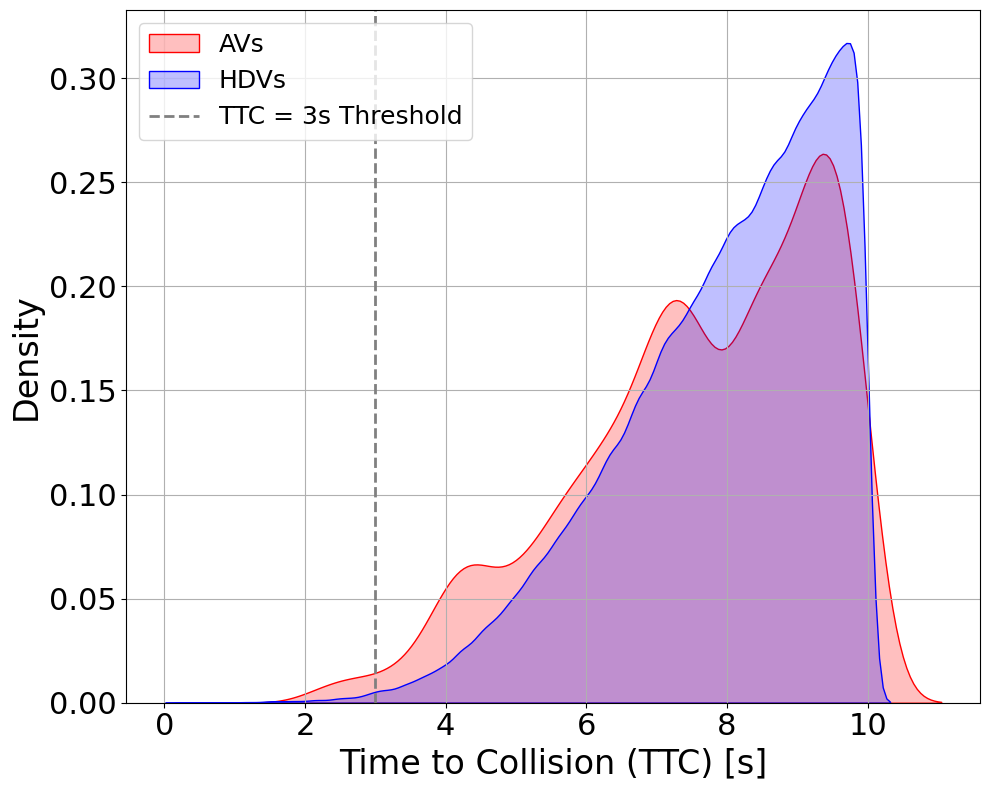

In [21]:
# KDE Plot: TTC Distribution 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
av_ttc = pd.read_csv("TTC_I395_AV.csv")
hdv_ttc = pd.read_csv("TTC_I395_HDV.csv")

# Remove large/infinite TTCs
ttc_threshold = 10
av_ttc = av_ttc[np.isfinite(av_ttc["TTC"]) & (av_ttc["TTC"] <= ttc_threshold)]
hdv_ttc = hdv_ttc[np.isfinite(hdv_ttc["TTC"]) & (hdv_ttc["TTC"] <= ttc_threshold)]

# KDE plot
plt.figure(figsize=(10, 8))
sns.kdeplot(av_ttc["TTC"], label="AVs", color="red", fill=True, bw_adjust=0.7)
sns.kdeplot(hdv_ttc["TTC"], label="HDVs", color="blue", fill=True, bw_adjust=0.7)
plt.axvline(3, color='gray', linestyle='--', linewidth=2, label="TTC = 3s Threshold")
plt.xlabel("Time to Collision (TTC) [s]", fontsize=24)
plt.ylabel("Density", fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=18, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.savefig("TTC_Distribution_I395.png", dpi=300)
plt.show()


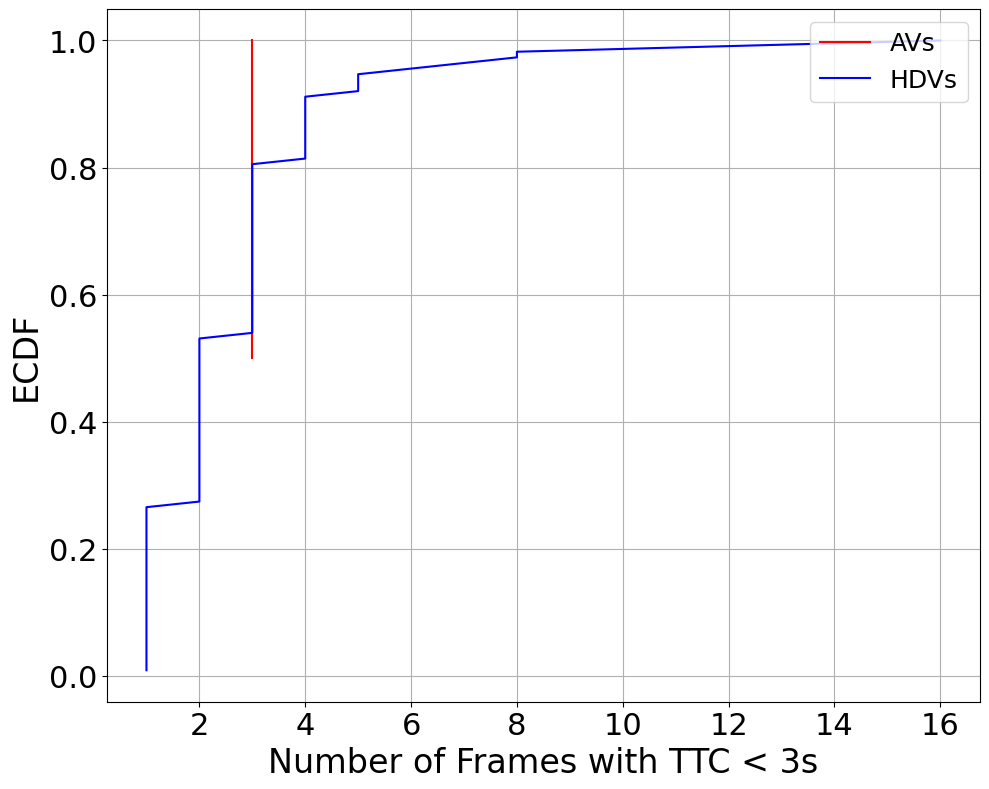

In [22]:
# ECDF Plot: Frames with TTC < 3s 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
av_ttc = pd.read_csv("TTC_I395_AV.csv")
hdv_ttc = pd.read_csv("TTC_I395_HDV.csv")

# Filter finite TTC values only
av_ttc = av_ttc[np.isfinite(av_ttc["TTC"])]
hdv_ttc = hdv_ttc[np.isfinite(hdv_ttc["TTC"])]

# Risk metric: frames with TTC < 3s
av_risk = av_ttc[av_ttc["TTC"] < 3].groupby("av_id").size()
hdv_risk = hdv_ttc[hdv_ttc["TTC"] < 3].groupby("hdv_id").size()

# ECDF function
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x_av, y_av = ecdf(av_risk)
x_hdv, y_hdv = ecdf(hdv_risk)

# ECDF plot
plt.figure(figsize=(10, 8))
plt.plot(x_av, y_av, label="AVs", color="red")
plt.plot(x_hdv, y_hdv, label="HDVs", color="blue")
plt.xlabel("Number of Frames with TTC < 3s", fontsize=24)
plt.ylabel("ECDF", fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=18, loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("ECDF_TTC_Under_3_I395.png", dpi=300)
plt.show()


## Post-Encroachment Time (PET) analysis

We computed PET values for AVs and HDVs in the I-395 dataset to capture interaction timing between vehicles traveling through shared or adjacent spaces. Each pair of agents was compared frame by frame to identify the minimum spatial separation. When the closest approach distance was below 2.5 meters, the absolute time difference between those positions was recorded as the PET. To handle the large number of agent pairs efficiently, we implemented parallel processing using `joblib`. The outputs (`PET_I395_AVs.csv` and `PET_I395_HDVs.csv`) provide detailed PET distributions for both automated and human-driven vehicles, supporting direct comparison of safety margins and temporal spacing behavior.


In [31]:
# PET calculation for AVs with parallel processing 

import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from datetime import datetime

start = datetime.now()

# Loading the transformed dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")

# Filtering and creating subsets — all AVs and all surrounding vehicles in relevant lanes
avs = tgsim[(tgsim["type_most_common"] == 4)]
av_ids = avs["id"].unique() 

agents = tgsim[(tgsim["type_most_common"].isin([1, 2, 3, 5])) &
               (tgsim["lane_kf"].isin([-4, -3, -2]))]["id"].unique()

# Creating interaction pairs, excluding self-pairs
interaction_pairs = [(av, agent) for av in av_ids for agent in agents if av != agent]

# Looping through each interaction pair — now in parallel
def compute_pet(av_id, agent_id):
    # Extracting the AV and agent trajectory data
    av_traj = tgsim[tgsim["id"] == av_id][["time", "xloc_kf", "yloc_kf"]].copy()
    agent_traj = tgsim[tgsim["id"] == agent_id][["time", "type_most_common", "xloc_kf", "yloc_kf"]].copy()

    # Skip if either trajectory is empty
    if av_traj.empty or agent_traj.empty:
        return None

    # Skip if time windows don’t overlap
    if av_traj["time"].max() < agent_traj["time"].min() or agent_traj["time"].max() < av_traj["time"].min():
        return None

    # Calculating distance using NumPy broadcasting
    av_coords = av_traj[["xloc_kf", "yloc_kf"]].values
    agent_coords = agent_traj[["xloc_kf", "yloc_kf"]].values
    dists = np.linalg.norm(av_coords[:, None, :] - agent_coords[None, :, :], axis=2)

    # Finding the closest point pair
    min_dist_idx = np.unravel_index(np.argmin(dists), dists.shape)
    min_dist = dists[min_dist_idx]

    # Skip if closest distance is more than 2.5 meters
    if min_dist > 2.5:
        return None

    # Computing PET
    t_av = av_traj.iloc[min_dist_idx[0]]["time"]
    t_agent = agent_traj.iloc[min_dist_idx[1]]["time"]
    type_agent = agent_traj.iloc[min_dist_idx[1]]["type_most_common"]
    pet = abs(t_av - t_agent)

    # Storing results
    return {
        "av_id": av_id,
        "agent_id": agent_id,
        "agent_type": type_agent,
        "av_time": t_av,
        "agent_time": t_agent,
        "PET": pet
    }

# Running the PET calculations in parallel using all available CPU cores
results = Parallel(n_jobs=-1)(delayed(compute_pet)(av, agent) for av, agent in interaction_pairs)

# Filtering out None results
pet_list = [r for r in results if r is not None]

# Saving results
df_pet = pd.DataFrame(pet_list)
df_pet.to_csv("PET_I395_AVs.csv", index=False)
print("AV PET dataset saved as 'PET_I395_AVs.csv'")

end = datetime.now()
print(f"Start: {start}, End: {end}, Duration: {end - start}")

AV PET dataset saved as 'PET_I395_AVs.csv'
Start: 2025-06-25 00:35:45.065047, End: 2025-06-25 00:43:09.754327, Duration: 0:07:24.689280


In [ ]:
# PET calculation for a sample of 200 HDVs with parallel processing 

import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from datetime import datetime

start = datetime.now()

# Loading the transformed dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")

# Filtering and creating subsets - we're taking a sample of HDVs to reduce processing time
eligible_hdvs = tgsim[(tgsim["type_most_common"] == 1) & (tgsim["lane_kf"] == -3)]
hdv_sample = eligible_hdvs.sample(n=200, random_state=42)
hdvs = hdv_sample["id"].unique()    # Expected to be slightly less than 200, in this case 197 

agents = tgsim[(tgsim["type_most_common"].isin([1, 2, 3, 4, 5])) &
               (tgsim["lane_kf"].isin([-4, -3, -2]))]["id"].unique()

# Creating interaction pairs, excluding self-pairs
interaction_pairs = [(hdv, agent) for hdv in hdvs for agent in agents if hdv != agent]

# Looping through each interaction pair — now in parallel
def compute_pet(hdv_id, agent_id):
    # Extracting the HDV and agent trajectory data
    hdv_traj = tgsim[tgsim["id"] == hdv_id][["time", "xloc_kf", "yloc_kf"]].copy()
    agent_traj = tgsim[tgsim["id"] == agent_id][["time", "type_most_common", "xloc_kf", "yloc_kf"]].copy()

    # Skip if either trajectory is empty
    if hdv_traj.empty or agent_traj.empty:
        return None

    # Skip if time windows don’t overlap
    if hdv_traj["time"].max() < agent_traj["time"].min() or agent_traj["time"].max() < hdv_traj["time"].min():
        return None

    # Calculating distance using NumPy broadcasting
    hdv_coords = hdv_traj[["xloc_kf", "yloc_kf"]].values
    agent_coords = agent_traj[["xloc_kf", "yloc_kf"]].values
    dists = np.linalg.norm(hdv_coords[:, None, :] - agent_coords[None, :, :], axis=2)

    # Finding the closest point pair
    min_dist_idx = np.unravel_index(np.argmin(dists), dists.shape)
    min_dist = dists[min_dist_idx]

    # Skip if closest distance is more than 2.5 meters
    if min_dist > 2.5:
        return None

    # Computing PET
    t_hdv = hdv_traj.iloc[min_dist_idx[0]]["time"]
    t_agent = agent_traj.iloc[min_dist_idx[1]]["time"]
    type_agent = agent_traj.iloc[min_dist_idx[1]]["type_most_common"]
    pet = abs(t_hdv - t_agent)

    # Storing results
    return {
        "hdv_id": hdv_id,
        "agent_id": agent_id,
        "agent_type": type_agent,
        "hdv_time": t_hdv,
        "agent_time": t_agent,
        "PET": pet
    }

# Running the PET calculations in parallel using all available CPU cores
results = Parallel(n_jobs=-1)(delayed(compute_pet)(hdv, agent) for hdv, agent in interaction_pairs)

# Filtering out None results
pet_list = [r for r in results if r is not None]

# Saving results
df_pet = pd.DataFrame(pet_list)
df_pet.to_csv("PET_I395_HDVs.csv", index=False)
print("HDV PET dataset saved as 'PET_I395_HDVs.csv'")

end = datetime.now()
print(f"Start: {start}, End: {end}, Duration: {end - start}")

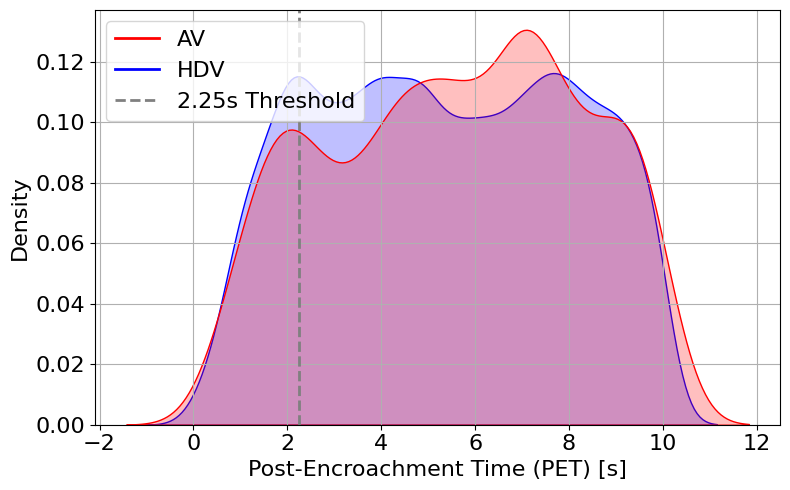

In [56]:
# KDE Plot: PET Distribution 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load PET datasets
av_pet = pd.read_csv("PET_I395_AVs.csv")
hdv_pet = pd.read_csv("PET_I395_HDVs.csv")

# Add vehicle type column
av_pet["vehicle_type"] = "AV"
hdv_pet["vehicle_type"] = "HDV"

# Combine datasets
df_all = pd.concat([av_pet[["PET", "vehicle_type"]], hdv_pet[["PET", "vehicle_type"]]])

# Filter PET values to a reasonable range (e.g., 0 to 10 seconds)
df_all = df_all[(df_all["PET"] >= 0) & (df_all["PET"] <= 10)]

# Plot KDE
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_all, x="PET", hue="vehicle_type", common_norm=False, fill=True, bw_adjust=0.7, palette={"AV": "red", "HDV": "blue"})

# Threshold line
plt.axvline(2.25, color='gray', linestyle='--', linewidth=2)

# Custom legend handles
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='AV'),
    Line2D([0], [0], color='blue', lw=2, label='HDV'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='2.25s Threshold')
]

plt.xlabel("Post-Encroachment Time (PET) [s]", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.legend(handles=legend_elements, fontsize=16, loc="upper left")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("PET_Distribution_AV_vs_HDV.png", dpi=300)
plt.show()


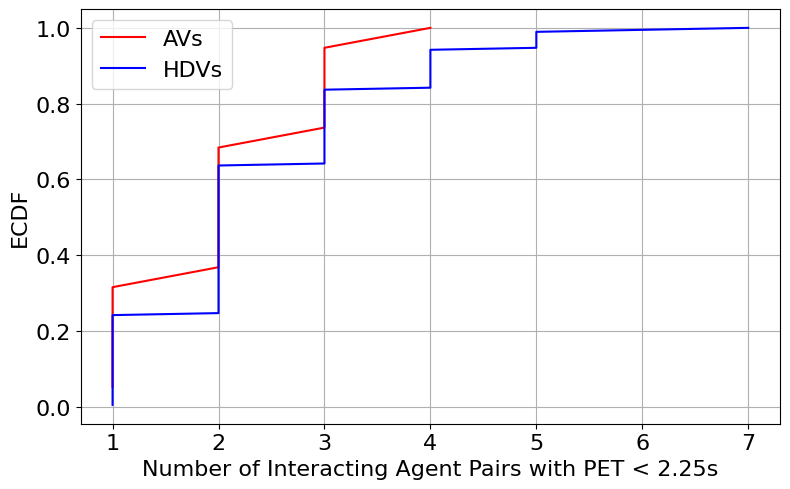

In [55]:
# ECDF Plot: Frames with PET < 5s 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load PET datasets
av_pet = pd.read_csv("PET_I395_AVs.csv")
hdv_pet = pd.read_csv("PET_I395_HDVs.csv")

# Filter for PET < 2.25 seconds
av_risk_pet = av_pet[av_pet["PET"] < 2.25].groupby("av_id").size()
hdv_risk_pet = hdv_pet[hdv_pet["PET"] < 2.25].groupby("hdv_id").size()

# Define ECDF function
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# Calculate ECDFs
x_av, y_av = ecdf(av_risk_pet)
x_hdv, y_hdv = ecdf(hdv_risk_pet)

# Plotting ECDF
plt.figure(figsize=(8, 5))
plt.plot(x_av, y_av, label="AVs", color="red")
plt.plot(x_hdv, y_hdv, label="HDVs", color="blue")

plt.xlabel("Number of Interacting Agent Pairs with PET < 2.25s", fontsize=16)
plt.ylabel("ECDF", fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("ECDF_PET_Under_2.25_I395.png", dpi=300)
plt.show()


## Platoon detection and gain analysis

We identified AV- and HDV-led platoons on lane −3 using an affine spacing model at the midpoint (y = 400 m). Leaders were determined by vehicle type, and followers were sequentially added if their observed spacing conformed to a dynamic distance rule, \( d = d_0 + h v \), within a 5 m tolerance. This approach reflects realistic car-following behavior based on headway and standstill spacing parameters drawn from prior studies.  

Once platoons were formed, acceleration data in ±10 s windows around the leader’s entry time were extracted to compute gain values, defined as the ratio of the follower’s acceleration norm to that of its predecessor. A cutoff of gain > 5 signaled instability and terminated the platoon chain. The resulting datasets:`AV_Platoons_I395_Mid.csv`, `HDV_Platoons_I395_Mid.csv`, and `I395_Gain_Comparison_Capped.csv` enable comparison of platoon formation tendencies and stability under AV and HDV leadership.


In [57]:
# AV platoons based on affine spacing - midpoint or y = 400m

import pandas as pd
import numpy as np

# Loading the full dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")

# Keeping only vehicles in lane -3
lane_filtered = tgsim[tgsim["lane_kf"] == -3].copy()
lane_filtered.sort_values(["id", "yloc_kf"], inplace=True)

# Extracting all vehicle IDs in lane -3
vehicle_ids = lane_filtered["id"].unique()

# Getting only AVs (type 4) as potential leaders
av_leader_ids = lane_filtered[lane_filtered["type_most_common"] == 4]["id"].unique()

records = []
used_ids = set()  # to track vehicles already assigned as followers

# Defining affine spacing parameters (from literature)
tolerance = 5.0
av_h, av_d0 = 1.0, 3.0
hdv_h, hdv_d0 = 2.0, 6.0

for av_id in av_leader_ids:
    if av_id in used_ids:
        continue  # skip if this AV was already used as a follower

    av_traj = lane_filtered[lane_filtered["id"] == av_id]
    t0 = av_traj.loc[av_traj["yloc_kf"] < 400, "time"].min()
    v0 = av_traj.loc[av_traj["time"] == t0, "speed_kf"].values[0]

    if np.isnan(v0) or v0 == 0:
        continue

    platoon = []

    # Starting with all vehicles in lane -3 as potential followers
    for follower_id in vehicle_ids:
        if follower_id == av_id or follower_id in used_ids:
            continue

        f_traj = lane_filtered[lane_filtered["id"] == follower_id]
        t_f = f_traj.loc[f_traj["yloc_kf"] < 400, "time"].min()

        # checking if it is actually following leader
        y_f = f_traj.loc[f_traj["time"] == t_f, "yloc_kf"]
        y_av = av_traj.loc[av_traj["time"] == t_f, "yloc_kf"]
        if y_f.empty or y_av.empty:
            continue
        if y_f.values[0] > y_av.values[0]:
            continue

        # checking if it is far behind
        if t_f > t0 + 10:
            break  

        # extracting follower speed
        v_f = f_traj.loc[f_traj["time"] == t_f, "speed_kf"].values[0]
        
        # follower type
        veh_type = f_traj["type_most_common"].iloc[0]

        # affine spacing
        h, d0 = (av_h, av_d0) if veh_type == 4 else (hdv_h, hdv_d0)

        d_actual = (t_f - t0) * v_f
        d_desired = d0 + h * v_f

        if d_actual <= d_desired + tolerance:
            platoon.append(follower_id)
            used_ids.add(follower_id)
        else:
            break  # platoon ends when affine spacing condition fails

    if platoon:
        records.append({
            "lead_id": av_id,
            "lead_entry_time": t0,
            "platoon_member_ids": platoon,
            "platoon_size": len(platoon)
        })

# Converting to dataFrame
platoon_df = pd.DataFrame(records)
platoon_df.to_csv("AV_Platoons_I395_Mid.csv", index=False)

done


In [61]:
# HDV platoons based on affine spacing - midpoint or y = 400m

import pandas as pd
import numpy as np

# Loading the full dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")

# Keeping only vehicles in lane -3
lane_filtered = tgsim[tgsim["lane_kf"] == -3].copy()
lane_filtered.sort_values(["id", "yloc_kf"], inplace=True)

# Extracting all vehicle IDs in lane -3
vehicle_ids = lane_filtered["id"].unique()

# Getting a random sample of 200 HDVs (type 1) as potential leaders
hdv_leader_ids = lane_filtered[lane_filtered["type_most_common"] == 1]["id"].drop_duplicates().sample(n=200, random_state=42).values

records = []
used_ids = set()  # to track vehicles already assigned as followers

# Defining affine spacing parameters (from literature)
tolerance = 5.0
av_h, av_d0 = 1.0, 3.0
hdv_h, hdv_d0 = 2.0, 6.0

for hdv_id in hdv_leader_ids:
    if hdv_id in used_ids:
        continue  # skip if this HDV was already used as a follower

    hdv_traj = lane_filtered[lane_filtered["id"] == hdv_id]
    hdv_cross = hdv_traj[hdv_traj["yloc_kf"] < 400]

    if hdv_cross.empty:
        continue

    t0 = hdv_cross["time"].min()
    v0_series = hdv_traj.loc[hdv_traj["time"] == t0, "speed_kf"]

    if v0_series.empty:
        continue

    v0 = v0_series.values[0]
    
    if np.isnan(v0) or v0 == 0:
        continue
    
    platoon = []

    # Starting with all vehicles in lane -3 as potential followers
    for follower_id in vehicle_ids:
        if follower_id == hdv_id or follower_id in used_ids:
            continue

        f_traj = lane_filtered[lane_filtered["id"] == follower_id]
        t_f = f_traj.loc[f_traj["yloc_kf"] < 400, "time"].min()

        # checking if it is actually following leader
        y_f = f_traj.loc[f_traj["time"] == t_f, "yloc_kf"]
        y_lead = hdv_traj.loc[hdv_traj["time"] == t_f, "yloc_kf"]
        if y_f.empty or y_lead.empty:
            continue
        if y_f.values[0] > y_lead.values[0]:
            continue

        # checking if it is far behind
        if t_f > t0 + 10:
            break  

        # extracting follower speed
        v_f = f_traj.loc[f_traj["time"] == t_f, "speed_kf"].values[0]
        
        # follower type
        veh_type = f_traj["type_most_common"].iloc[0]

        # affine spacing
        h, d0 = (av_h, av_d0) if veh_type == 4 else (hdv_h, hdv_d0)

        d_actual = (t_f - t0) * v_f
        d_desired = d0 + h * v_f

        if d_actual <= d_desired + tolerance:
            platoon.append(follower_id)
            used_ids.add(follower_id)
        else:
            break  # platoon ends when affine spacing condition fails

    if platoon:
        records.append({
            "lead_id": hdv_id,
            "lead_entry_time": t0,
            "platoon_member_ids": platoon,
            "platoon_size": len(platoon)
        })

# Converting to dataFrame
platoon_df = pd.DataFrame(records)
platoon_df.to_csv("HDV_Platoons_I395_Mid.csv", index=False)


In [89]:
# Calculating gain with cutoff: skip rest of platoon if gain > 5

import pandas as pd
import numpy as np

# Loading the full transformed dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")

# Keeping only vehicles in lane -3
tgsim = tgsim[tgsim["lane_kf"] == -3].copy()

# Loading platoon datasets for AVs and HDVs
platoons_av = pd.read_csv("AV_Platoons_I395_Mid.csv")
platoons_hdv = pd.read_csv("HDV_Platoons_I395_Mid.csv")

# This function extracts the acceleration norm signal
def get_acc_signal(agent_id, center_time):
    # Filtering and sorting the vehicle trajectory
    traj = tgsim[tgsim["id"] == agent_id].copy()
    traj = traj.sort_values("time")

    # Extracting data in a 20-second window centered around platoon time
    traj = traj[(traj["time"] >= center_time - 10) & (traj["time"] <= center_time + 10)]
    if traj.empty:
        return None

    # Computing acceleration norm 
    traj["acc_norm"] = np.sqrt(traj["acceleration_kf"] ** 2)
    return traj["acc_norm"].values

# This function computes gains for each platoon and follower
# Platoon is broken once gain exceeds a defined threshold (e.g., 5)
def compute_gains(platoons_df, veh_type, gain_threshold=5):
    results = []

    # Looping through each platoon
    for _, row in platoons_df.iterrows():
        lead_id = row["lead_id"]              # Extract platoon leader ID
        t0 = row["lead_entry_time"]           # Get entry time for the leader (used as reference)
        members = eval(row["platoon_member_ids"])  # Convert string to list of follower IDs

        # Get acceleration norm for the leader
        a_lead = get_acc_signal(lead_id, t0)
        if a_lead is None or len(a_lead) < 2:
            continue

        # Compute L2 norm of leader's acceleration
        norm_prev = np.linalg.norm(a_lead)
        if norm_prev == 0:
            continue

        # Loop through each follower in the platoon
        for i, fid in enumerate(members):
            # Get entry time of the follower
            t_f = tgsim[tgsim["id"] == fid]["time"].min()

            # Get follower's acceleration signal
            a_f = get_acc_signal(fid, t_f)
            if a_f is None or len(a_f) < 2:
                continue

            # Compute L2 norm of follower's acceleration
            norm_f = np.linalg.norm(a_f)

            # Compute gain as the ratio of follower's norm to predecessor's norm
            gain = norm_f / norm_prev if norm_prev > 0 else np.inf

            # Break the platoon if gain exceeds threshold
            if gain > gain_threshold:
                break  # platoon response no longer stable

            # Save result with positional index and lead type
            results.append({
                "lead_id": lead_id,
                "follower_id": fid,
                "platoon_pos": i + 1,
                "gain": gain,
                "lead_type": veh_type
            })

            # Update reference for next follower
            norm_prev = norm_f

    return pd.DataFrame(results)

# Compute gains for AV- and HDV-led platoons
gain_av = compute_gains(platoons_av, "AV")
gain_hdv = compute_gains(platoons_hdv, "HDV")

# Combine and export all gain values
gain_df = pd.concat([gain_av, gain_hdv], ignore_index=True)
gain_df.to_csv("I395_Gain_Comparison_Capped.csv", index=False)


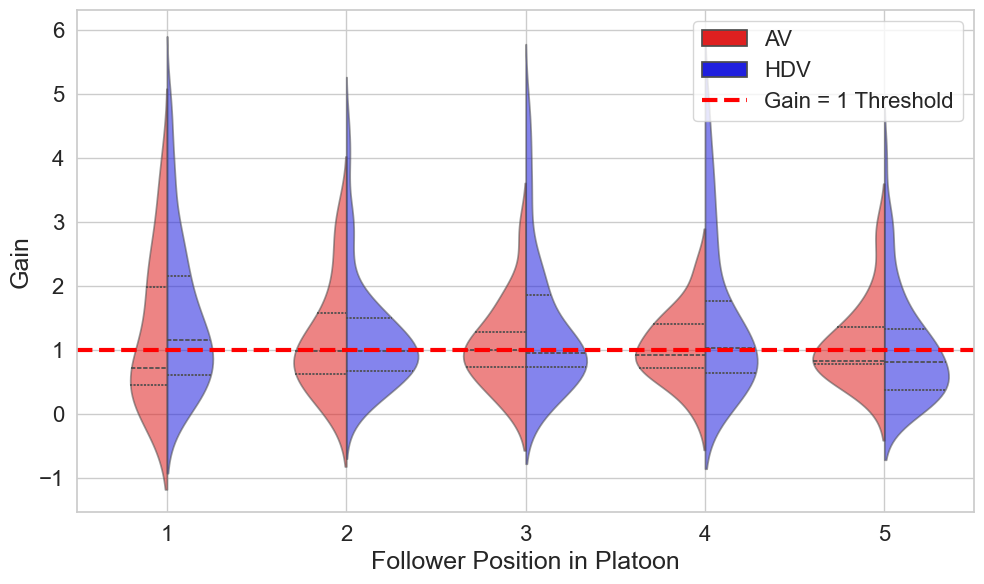

In [2]:
# Visualizing gain per platoon position

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load gain data
gain_df = pd.read_csv("I395_Gain_Comparison_Capped.csv")

# Keep only positions 1 to 5
gain_df = gain_df[gain_df["platoon_pos"].between(1, 5)]

# Set seaborn style
sns.set(style="whitegrid")

# Define consistent colors
custom_palette = {"AV": "red", "HDV": "blue"}

# Create the violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    data=gain_df,
    x="platoon_pos",
    y="gain",
    hue="lead_type",
    split=True,
    inner="quartile",
    palette=custom_palette
)

# Set transparency
for violin in ax.collections:
    violin.set_alpha(0.55)

# Threshold line
plt.axhline(1.0, color="red", linewidth=3, linestyle="--", label="Gain = 1 Threshold")

# Labels and styling
plt.xlabel("Follower Position in Platoon", fontsize=18)
plt.ylabel("Gain", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("Gain_Violin_By_Position_I395.png", dpi=300)
plt.show()


## Headway analysis

We estimated instantaneous time headways for AVs and HDVs traveling in lane −3. At each time step, every vehicle’s position and speed were compared with the nearest vehicle ahead (smaller y-location). The spatial gap was divided by the follower’s speed to obtain the time headway. Only interactions within 90 m and with headway values below 5 s were retained to represent active car-following conditions.  

For AVs, the computation included all type 4 vehicles, while a random sample of 100 type 1 vehicles was used for HDVs to limit processing time. The outputs (`I395_AV_Headway.csv` and `I395_HDV_Headway.csv`) capture second-by-second variations in inter-vehicle spacing and provide empirical inputs for evaluating flow efficiency and following behavior across automation levels.


In [120]:
# Generating headway data for AVs

import pandas as pd
import numpy as np
from tqdm import tqdm

# Loading data
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
tgsim = tgsim[tgsim["lane_kf"] == -3].copy()

# Focus on AVs (type_most_common == 4)
av_ids = tgsim[tgsim["type_most_common"] == 4]["id"].unique()

# Optional: sample every Nth timestep
unique_times = sorted(tgsim["time"].unique()) # we use this in the for loop if we want a 0.1 sec resolution
sampled_times = unique_times[::10]         # 1 sec resolution

headway_records = []

# Looping through all time units
for t in tqdm(unique_times):
    df_t = tgsim[tgsim["time"] == t]

    for av_id in av_ids:
        av_row = df_t[df_t["id"] == av_id]
        if av_row.empty:
            continue

        # Extracting current vehicle's data
        x_av = av_row["xloc_kf"].values[0]
        y_av = av_row["yloc_kf"].values[0]
        v_av = av_row["speed_kf"].values[0]

        if v_av <= 0:
            continue

        # Finding vehicles ahead (smaller y) excluding the same veh
        ahead = df_t[(df_t["yloc_kf"] < y_av) & (df_t["id"] != av_id)]

        if ahead.empty:
            continue

        lead_row = ahead.loc[ahead["yloc_kf"].idxmax()]
        gap = np.sqrt((lead_row["xloc_kf"] - x_av)**2 + (lead_row["yloc_kf"] - y_av)**2)

        time_headway = gap / v_av
        
        if gap <= 90 and time_headway<5:
            headway_records.append({
                "time": t,
                "av_id": av_id,
                "xloc_kf": x_av,
                "yloc_kf": y_av,
                "lead_id": lead_row["id"],
                "gap": gap,
                "av_speed": v_av,
                "headway_time": time_headway
            })

# Converting to DataFrame
headway_df = pd.DataFrame(headway_records)
headway_df.to_csv("I395_AV_Headway.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████| 71847/71847 [05:55<00:00, 201.92it/s]


In [124]:
# Generating headway data for HDVs

import pandas as pd
import numpy as np
from tqdm import tqdm

# Loading data
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
tgsim = tgsim[tgsim["lane_kf"] == -3].copy()

# Focus on HDVs (type_most_common == 1)
hdv_ids = tgsim[tgsim["type_most_common"] == 1]["id"].drop_duplicates().sample(n=100, random_state=42).values

# Optional: sample every Nth timestep
unique_times = sorted(tgsim["time"].unique()) # we use this in the for loop if we want a 0.1 sec resolution
sampled_times = unique_times[::10]         # 1 sec resolution

headway_records = []

# Looping through all time units
for t in tqdm(unique_times):
    df_t = tgsim[tgsim["time"] == t]

    for hdv_id in hdv_ids:
        hdv_row = df_t[df_t["id"] == hdv_id]
        if hdv_row.empty:
            continue

        # Extracting current vehicle's data
        x_hdv = hdv_row["xloc_kf"].values[0]
        y_hdv = hdv_row["yloc_kf"].values[0]
        v_hdv = hdv_row["speed_kf"].values[0]

        if v_hdv <= 0:
            continue

        # Finding vehicles ahead (smaller y) excluding the same veh
        ahead = df_t[(df_t["yloc_kf"] < y_hdv) & (df_t["id"] != hdv_id)]

        if ahead.empty:
            continue

        lead_row = ahead.loc[ahead["yloc_kf"].idxmax()]
        gap = np.sqrt((lead_row["xloc_kf"] - x_hdv)**2 + (lead_row["yloc_kf"] - y_hdv)**2)

        time_headway = gap / v_hdv
        
        if gap <= 90 and time_headway<5:
            headway_records.append({
                "time": t,
                "hdv_id": hdv_id,
                "xloc_kf": x_hdv,
                "yloc_kf": y_hdv,
                "lead_id": lead_row["id"],
                "gap": gap,
                "hdv_speed": v_hdv,
                "headway_time": time_headway
            })

# Converting to DataFrame
headway_df = pd.DataFrame(headway_records)
headway_df.to_csv("I395_HDV_Headway.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████| 71847/71847 [23:33<00:00, 50.82it/s]


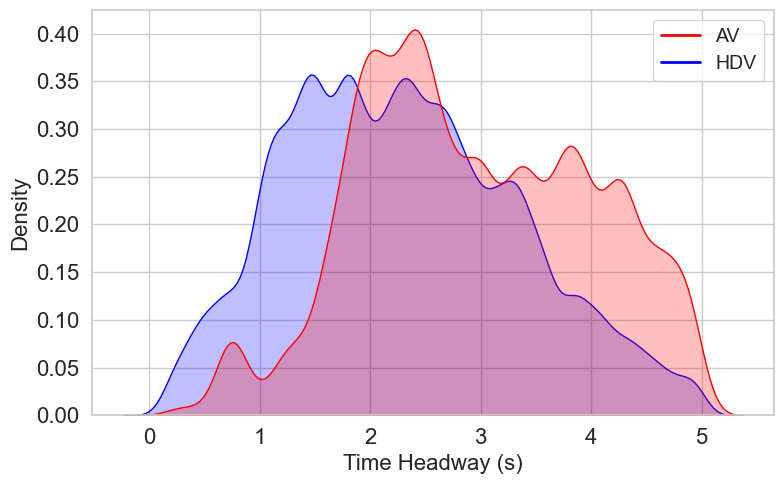

In [58]:
# Visualizing headway

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load headway datasets
av_headway = pd.read_csv("I395_AV_Headway.csv")
hdv_headway = pd.read_csv("I395_HDV_Headway.csv")

# Add label for lead type
av_headway["follower_type"] = "AV"
hdv_headway["follower_type"] = "HDV"

# Unify column names
av_headway = av_headway.rename(columns={"headway_time": "headway"})
hdv_headway = hdv_headway.rename(columns={"headway_time": "headway"})

# Combine datasets
headway_df = pd.concat([av_headway[["headway", "follower_type"]],
                        hdv_headway[["headway", "follower_type"]]],
                       ignore_index=True)

# Plot settings
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Kernel Density Plot
sns.kdeplot(data=headway_df, x="headway", hue="follower_type", palette={"AV": "red", "HDV": "blue"},
            common_norm=False, fill=True, bw_adjust=0.7)

legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='AV'),
    Line2D([0], [0], color='blue', lw=2, label='HDV'),
]


# Styling
plt.xlabel("Time Headway (s)", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(handles=legend_elements, fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("Headway_KDE_I395.png", dpi=300)
plt.show()


## Deceleration analysis

We identified and compared deceleration events for AVs and HDVs operating in lane −3. Frames with negative longitudinal acceleration values were isolated, and magnitudes were converted to positive deceleration rates. This allowed the extraction of braking behavior intensity across vehicle types.  

The resulting dataset (`Intense_Deceleration_Events_I395.csv`) includes all decelerating instances for AVs (type 4) and HDVs (type 1). 

In [139]:
# Deceleration intensity

import pandas as pd
import numpy as np

# Loading the transformed dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")

# Filtering to include only decelerating AVs and HDVs on lane -3
tgsim = tgsim[(tgsim["type_most_common"].isin([1, 4])) & (tgsim["lane_kf"] == -3) & (tgsim["acceleration_kf"] < 0)]

# Converting to positive for convenience and consistency
tgsim["deceleration"] = tgsim["acceleration_kf"].abs()

# Converting to a df and saving
tgsim.to_csv("Intense_Deceleration_Events_I395.csv", index=False)


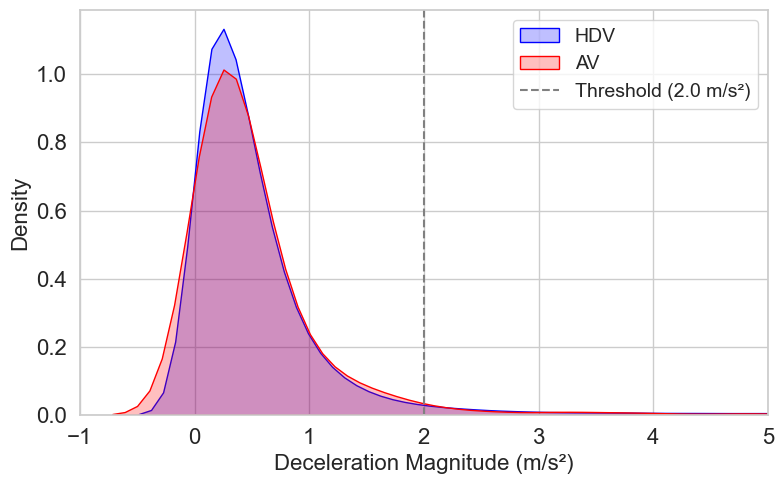

In [61]:
# Visualizing deceleation

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load prefiltered deceleration data
tgsim = pd.read_csv("Intense_Deceleration_Events_I395.csv")

# Map vehicle types for labeling
tgsim["veh_type"] = tgsim["type_most_common"].map({4: "AV", 1: "HDV"})

# Plot settings
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

sns.kdeplot(
    data=tgsim[tgsim["veh_type"] == "HDV"],
    x="deceleration",
    label="HDV",
    color="blue",
    fill=True,
    bw_adjust=0.7
)

sns.kdeplot(
    data=tgsim[tgsim["veh_type"] == "AV"],
    x="deceleration",
    label="AV",
    color="red",
    fill=True,
    bw_adjust=0.7
)

plt.axvline(x=2.0, color='gray', linestyle='--', label='Threshold (2.0 m/s²)')

# Styling
plt.xlabel("Deceleration Magnitude (m/s²)", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-1,5)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("Deceleration_KDE_I395.png", dpi=300)
plt.show()


## Jerk analysis

We quantified jerk behavior for AVs and HDVs traveling in lane −3 by differentiating smoothed longitudinal acceleration profiles. For each vehicle, acceleration signals were first filtered with a centered rolling mean to suppress noise, then differentiated over 0.1 s intervals to compute instantaneous jerk. A 1 s moving window was used to calculate root mean square (RMS) jerk, capturing overall intensity within short motion bursts.  

Only the most intense jerk event per vehicle was retained, producing `Jerk_I395.csv`. This dataset summarizes the spatial and kinematic context of abrupt motion changes, enabling comparison of comfort and control smoothness between automated and human-driven vehicles.


In [184]:
# Jerk Behavior

import pandas as pd
import numpy as np

# Loading the transformed dataset
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")

# Filtering to include only AVs and HDVs on lane -3
tgsim = tgsim[(tgsim["type_most_common"].isin([1, 4])) & (tgsim["lane_kf"] == -3)]

window_size = 10  # 1 second 
jerky_summary = []

for agent_id, group in tgsim.groupby("id"):
    group = group.sort_values("time")

    acc_raw = group["acceleration_kf"].values

    # Skip short tracks
    if len(acc_raw) < window_size + 1:  # jerk will be len-1
        continue

    # Apply rolling mean to smooth acceleration
    acc = pd.Series(acc_raw).rolling(window=5, center=True, min_periods=1).mean().values

    # Compute jerk (derivative of smoothed acceleration)
    jerk = np.diff(acc) / 0.1

    # We now want to keep only the most intense jerk window per vehicle
    max_rms_jerk = -np.inf
    best_window_data = None

    # Looping through rolling windows of jerk values
    for i in range(len(jerk) - window_size + 1):
        jerk_window = jerk[i:i + window_size]
        rms_jerk = np.sqrt(np.mean(jerk_window**2))

        # +5 for smoothing lag, +1 for np.diff offset
        center_idx = i + 5 + 1
        if center_idx >= len(group):
            continue

        # Store this window if it has the highest RMS jerk so far
        if rms_jerk > max_rms_jerk:
            max_rms_jerk = rms_jerk
            best_window_data = {
                "id": agent_id,
                "rms_jerk": rms_jerk,
                "max_jerk": jerk_window.max(),
                "min_jerk": jerk_window.min(),
                "time": group.iloc[center_idx]["time"],
                "speed_kf": group.iloc[center_idx]["speed_kf"],
                "xloc_kf": group.iloc[center_idx]["xloc_kf"],
                "yloc_kf": group.iloc[center_idx]["yloc_kf"],
                "acceleration_kf": group.iloc[center_idx]["acceleration_kf"],
                "type_most_common": group.iloc[center_idx]["type_most_common"]
            }

    if best_window_data:
        jerky_summary.append(best_window_data)

# Save only the single strongest jerk instance per vehicle
jerky_df = pd.DataFrame(jerky_summary)
jerky_df.to_csv("Jerk_I395.csv", index=False)


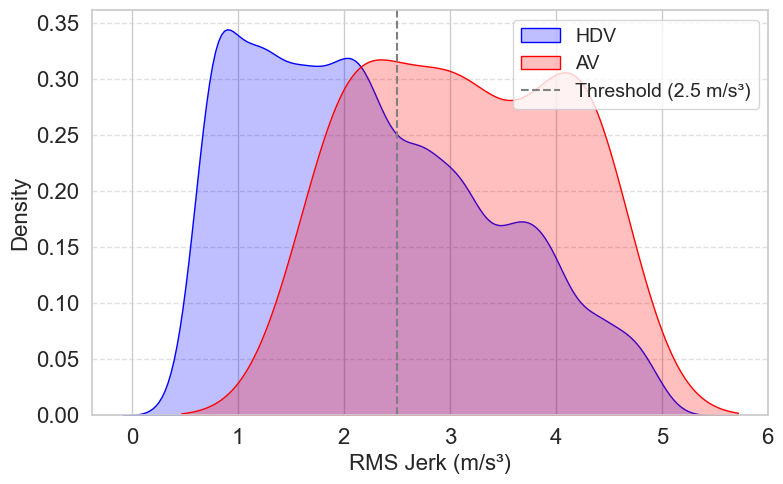

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the transformed dataset
jerky_df = pd.read_csv("Jerk_I395.csv")
jerky_df = jerky_df[(jerky_df["rms_jerk"] <= 5)]

# Label vehicle types
jerky_df["Vehicle Type"] = jerky_df["type_most_common"].map({1: "HDV", 4: "AV"})


# Plot settings



sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.kdeplot(data=jerky_df[jerky_df["Vehicle Type"] == "HDV"], x="rms_jerk", label="HDV", color="blue", fill=True, bw_adjust=0.7)
sns.kdeplot(data=jerky_df[jerky_df["Vehicle Type"] == "AV"], x="rms_jerk", label="AV", color="red", fill=True, bw_adjust=0.7)

plt.axvline(x=2.5, color='gray', linestyle='--', label='Threshold (2.5 m/s³)')
plt.xlabel("RMS Jerk (m/s³)", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14, title_fontsize=14, loc="upper right")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("RMS_Jerk_KDE_I395.png", dpi=300)
plt.show()

## Proximity analysis

We analyzed spatial proximity patterns between AVs and HDVs in lanes −2, −3, and −4. At each 0.1 s time step, every vehicle in lane −3 (AV or HDV) was treated as a reference (ego) and its Euclidean distance to all other nearby agents was computed. Interactions within 20 m were classified as proximity events.  

Consecutive frames with gaps shorter than 0.5 s were grouped into the same “episode,” representing a continuous close interaction between two vehicles. For each episode, key statistics, including start and end time, duration, and distance metrics, were calculated and stored in `Proximity_I395.csv`. These episodes provide detailed information on the temporal and spatial structure of vehicle encounters in mixed traffic.


In [11]:
# Proximity analysis

import pandas as pd
import numpy as np
from joblib import Parallel, delayed

tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
tgsim = tgsim[tgsim["lane_kf"].isin([-2, -3, -4])]
tgsim["key"] = list(zip(tgsim["time"], tgsim["id"]))

grouped_by_time = dict(tuple(tgsim.groupby("time")))
proximity_threshold = 20

def compute_proximity(time, df_at_time):
    results = []
    ref_agents = df_at_time[(df_at_time["lane_kf"] == -3) & (df_at_time["type_most_common"].isin([1, 4]))]
    others = df_at_time[~df_at_time["id"].isin(ref_agents["id"])].copy()

    for _, ref in ref_agents.iterrows():
        x1, y1 = ref["xloc_kf"], ref["yloc_kf"]
        ref_id = ref["id"]
        ref_type = ref["type_most_common"]

        others["dist"] = np.sqrt((others["xloc_kf"] - x1)**2 + (others["yloc_kf"] - y1)**2)
        close_agents = others[others["dist"] <= proximity_threshold]

        for _, row in close_agents.iterrows():
            results.append({
                "time": time,
                "ego_id": ref_id,
                "ego_type": ref_type,
                "ego_lane": ref["lane_kf"],
                "agent_id": row["id"],
                "agent_type": row["type_most_common"],
                "agent_lane": row["lane_kf"],
                "distance": row["dist"]
            })
    return results

# Run in parallel using all available cores
all_results = Parallel(n_jobs=-1)(delayed(compute_proximity)(time, df) for time, df in grouped_by_time.items())

# Flatten and save
flat_results = [record for sublist in all_results for record in sublist]
proximity_df = pd.DataFrame(flat_results)

# Sort values for proper episode tracking
proximity_df.sort_values(by=["ego_id", "agent_id", "time"], inplace=True)

# Create a flag for whether the time difference to the previous row is > 0.3s (3 timesteps to address noise issues)
proximity_df["prev_time"] = proximity_df.groupby(["ego_id", "agent_id"])["time"].shift(1)
proximity_df["break"] = (proximity_df["time"] - proximity_df["prev_time"]) > 0.5

# Assign episode IDs by cumulative sum of breaks
proximity_df["episode_id"] = proximity_df.groupby(["ego_id", "agent_id"])["break"].cumsum()

# Group by episode to get stats
episodes = (
    proximity_df
    .groupby(["ego_id", "agent_id", "episode_id"])
    .agg(
        start_time=("time", "min"),
        end_time=("time", "max"),
        duration=("time", lambda x: round((x.max() - x.min()) + 0.1, 2)),
        min_dist=("distance", "min"),
        max_dist=("distance", "max"),
        mean_dist=("distance", "mean"),
        ego_type=("ego_type", "first"),
        agent_type=("agent_type", "first"),
        ego_lane=("ego_lane", "first"),
        agent_lane=("agent_lane", "first")
    )
    .reset_index()
)

episodes.to_csv("Proximity_I395.csv", index=False)

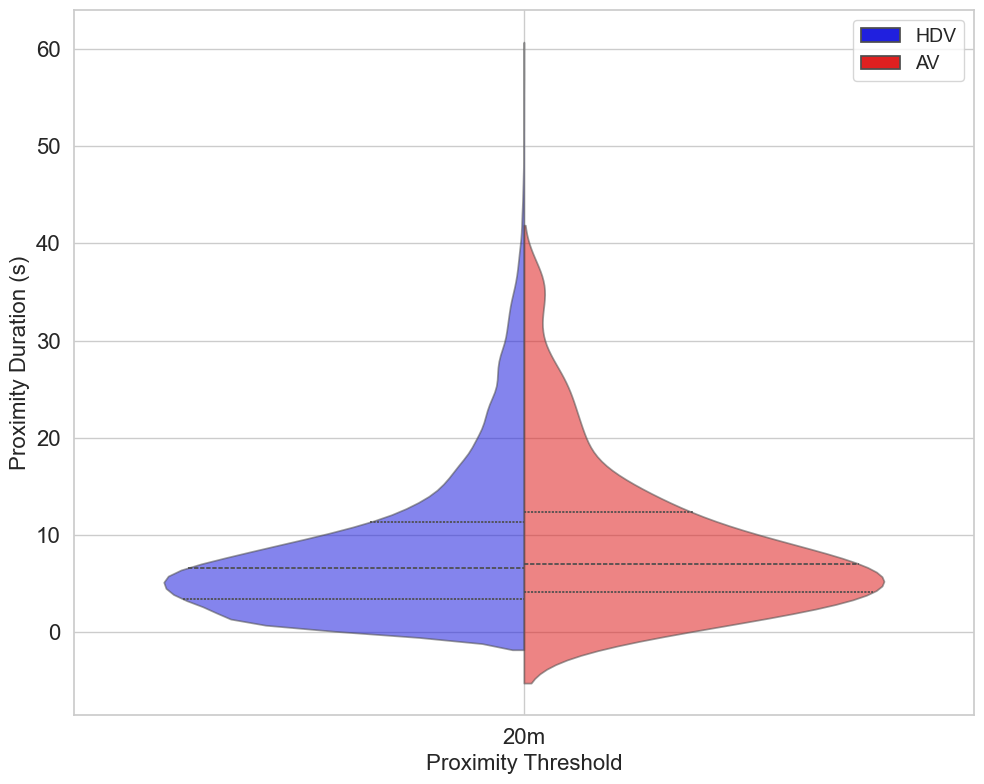

In [10]:
# Visualizing proximity

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the proximity episode data
prox_episodes = pd.read_csv("Proximity_I395.csv")

# Add vehicle label (AV or HDV) based on ego_type
prox_episodes["vehicle"] = prox_episodes["ego_type"].map({4: "AV", 1: "HDV"})

# Add threshold column for plotting (constant in this case)
prox_episodes["threshold"] = "20m"

# Set style
sns.set(style="whitegrid")

# --- VIOLIN PLOT ---
plt.figure(figsize=(10, 8))

custom_palette = {
    "AV": "red",
    "HDV": "blue"
}

ax = sns.violinplot(
    data=prox_episodes,
    x="threshold",
    y="duration",
    hue="vehicle",
    split=True,
    inner="quart",
    palette=custom_palette
)

# Transparency
for violin in ax.collections:
    violin.set_alpha(0.55)

# Axis and label formatting
plt.xlabel("Proximity Threshold", fontsize=16)
plt.ylabel("Proximity Duration (s)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14, title_fontsize=14, loc="upper right")
plt.grid(axis="y")
ax.grid(True)

plt.tight_layout()
plt.savefig("Proximity_Violin_Plot.png", dpi=300)
plt.show()


## Speed profile analysis

We analyzed the instantaneous speed interactions of AVs relative to nearby vehicles across three adjacent lanes (−4 to −2). Each AV served as a reference, and its surrounding traffic within a 50 m radius was examined at 0.1 s intervals. Neighboring vehicles were classified as leading, following, left-lane, or right-lane agents, with positional gaps and motion variables recorded for each pair.  

The resulting dataset (`speed_profiles_50.csv`) provides synchronized snapshots of AVs and nearby vehicles, capturing their relative speed, acceleration, and spacing. These data support subsequent evaluation of lane-dependent interactions and car-following dynamics.


In [248]:
# Speed profiles

import pandas as pd
import numpy as np

# Importing and filtering for lane and adjacent lanes
tgsim = pd.read_csv("Transformed_TGSIM_I-395.csv")
tgsim = tgsim[tgsim["lane_kf"].isin([-2, -3, -4])]
avs = tgsim[tgsim["type_most_common"] == 4]
av_ids = avs["id"].unique()

sp_records = []

for av_id in av_ids:
    av_traj = avs[avs["id"] == av_id]
    start_time = max(av_traj["time"].min() - 5, tgsim["time"].min())
    end_time = av_traj["time"].max() + 5

    for time in np.arange(start_time, end_time + 0.05, 0.1):
        time = round(time, 1)  # Mitigates floating point error
        av_row = av_traj[av_traj["time"] == time]
        if av_row.empty:
            continue

        x_av = av_row["xloc_kf"].values[0]
        y_av = av_row["yloc_kf"].values[0]
        v_av = av_row["speed_kf"].values[0]
        a_av = av_row["acceleration_kf"].values[0]

        if v_av <= 0:
            continue

        agents_traj = tgsim[(tgsim["time"] == time) & (tgsim["id"] != av_id)]

        # Lead and follow agents in same lane
        same_lane_agents = agents_traj[agents_traj["lane_kf"] == -3]
        lead = same_lane_agents[same_lane_agents["yloc_kf"] < y_av].copy()
        lead["location"] = "lead"
        lead["spacing"] = np.sqrt((lead["xloc_kf"] - x_av)**2 + (lead["yloc_kf"] - y_av)**2)
        follow = same_lane_agents[same_lane_agents["yloc_kf"] > y_av].copy()
        follow["location"] = "follow"
        follow["spacing"] = np.sqrt((follow["xloc_kf"] - x_av)**2 + (follow["yloc_kf"] - y_av)**2)

        if not lead.empty:
            lead_row = lead.loc[lead["yloc_kf"].idxmax()]
            sp_records.append({
                "time": time,
                "av_id": av_id,
                "av_speed": v_av,
                "av_acceleration": a_av,
                "av_xloc_kf": x_av,
                "av_yloc_kf": y_av,
                "agent_id": lead_row["id"],
                "agent_location": lead_row["location"],
                "gap": lead_row["spacing"],
                "agent_type": lead_row["type_most_common"],
                "agent_speed": lead_row["speed_kf"],
                "agent_acceleration": lead_row["acceleration_kf"],
                "agent_xloc_kf": lead_row["xloc_kf"],
                "agent_yloc_kf": lead_row["yloc_kf"]
            })

        if not follow.empty:
            follow_row = follow.loc[follow["yloc_kf"].idxmin()]
            sp_records.append({
                "time": time,
                "av_id": av_id,
                "av_speed": v_av,
                "av_acceleration": a_av,
                "av_xloc_kf": x_av,
                "av_yloc_kf": y_av,
                "agent_id": follow_row["id"],
                "agent_location": follow_row["location"],
                "gap": follow_row["spacing"],
                "agent_type": follow_row["type_most_common"],
                "agent_speed": follow_row["speed_kf"],
                "agent_acceleration": follow_row["acceleration_kf"],
                "agent_xloc_kf": follow_row["xloc_kf"],
                "agent_yloc_kf": follow_row["yloc_kf"]
            })

        # Left lane
        l_agents = agents_traj[agents_traj["lane_kf"] == -2].copy()
        l_agents["spacing"] = np.sqrt((l_agents["xloc_kf"] - x_av)**2 + (l_agents["yloc_kf"] - y_av)**2)
        l_agents = l_agents[l_agents["spacing"] <= 50]
        l_agents["location"] = "left"
        for _, agent_row in l_agents.iterrows():
            sp_records.append({
                "time": time,
                "av_id": av_id,
                "av_speed": v_av,
                "av_acceleration": a_av,
                "av_xloc_kf": x_av,
                "av_yloc_kf": y_av,
                "agent_id": agent_row["id"],
                "agent_location": agent_row["location"],
                "gap": agent_row["spacing"],
                "agent_type": agent_row["type_most_common"],
                "agent_speed": agent_row["speed_kf"],
                "agent_acceleration": agent_row["acceleration_kf"],
                "agent_xloc_kf": agent_row["xloc_kf"],
                "agent_yloc_kf": agent_row["yloc_kf"]
            })

        # Right lane
        r_agents = agents_traj[agents_traj["lane_kf"] == -4].copy()
        r_agents["spacing"] = np.sqrt((r_agents["xloc_kf"] - x_av)**2 + (r_agents["yloc_kf"] - y_av)**2)
        r_agents = r_agents[r_agents["spacing"] <= 50]
        r_agents["location"] = "right"
        for _, agent_row in r_agents.iterrows():
            sp_records.append({
                "time": time,
                "av_id": av_id,
                "av_speed": v_av,
                "av_acceleration": a_av,
                "av_xloc_kf": x_av,
                "av_yloc_kf": y_av,
                "agent_id": agent_row["id"],
                "agent_location": agent_row["location"],
                "gap": agent_row["spacing"],
                "agent_type": agent_row["type_most_common"],
                "agent_speed": agent_row["speed_kf"],
                "agent_acceleration": agent_row["acceleration_kf"],
                "agent_xloc_kf": agent_row["xloc_kf"],
                "agent_yloc_kf": agent_row["yloc_kf"]
            })

sp_df = pd.DataFrame(sp_records)
sp_df.to_csv("speed_profiles_50.csv", index=False)

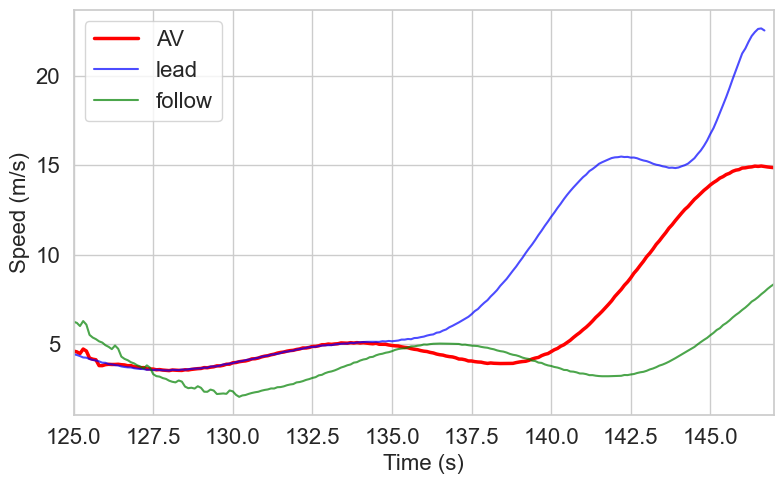

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the speed profiles
sp_df = pd.read_csv("speed_profiles.csv")
sp_df = sp_df[sp_df["agent_location"].isin(["lead", "follow"])]

# Select one AV ID to plot
av_id = 694
av_df = sp_df[sp_df["av_id"] == av_id]

# AV speed trace
av_trace = av_df[["time", "av_speed"]].drop_duplicates()

# Plot setup
plt.figure(figsize=(8, 5))
plt.plot(av_trace["time"], av_trace["av_speed"], color='red', linewidth=2.5, label='AV')

# Agent traces by location
locations = {
    "lead": "blue",
    "follow": "green",
    "left": "gray",
    "right": "purple"
}

for location, color in locations.items():
    agents = av_df[av_df["agent_location"] == location]
    for agent_id, group in agents.groupby("agent_id"):
        plt.plot(group["time"], group["agent_speed"], color=color, alpha=0.7, label=location)

# Avoid duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=16)

plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Speed (m/s)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(125, 147)
#plt.ylim(0, 17)
plt.grid(True)
plt.tight_layout()
plt.savefig("Speed_Propagation_I395.png", dpi=300)
plt.show()


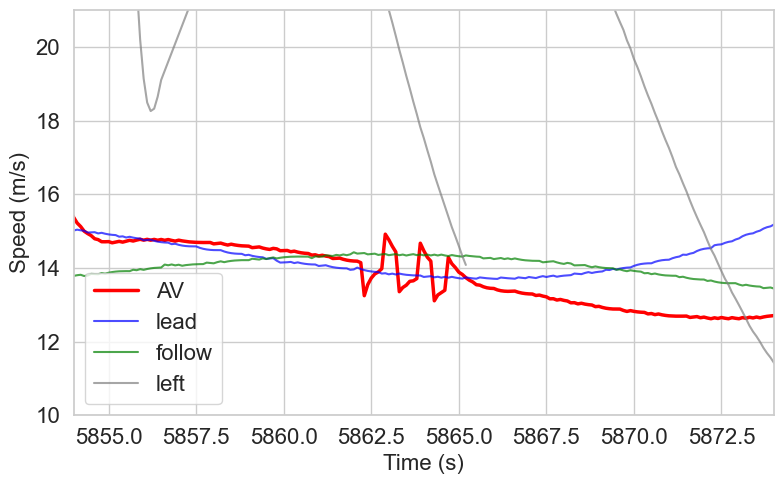

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the speed profiles
sp_df = pd.read_csv("speed_profiles.csv")
sp_df = sp_df[sp_df["agent_location"].isin(["lead", "follow", "left"])]

# Select one AV ID to plot 8885  9409  9505 10150 10182
av_id = 8885
av_df = sp_df[sp_df["av_id"] == av_id]

# AV speed trace
av_trace = av_df[["time", "av_speed"]].drop_duplicates()

# Plot setup
plt.figure(figsize=(8, 5))
plt.plot(av_trace["time"], av_trace["av_speed"], color='red', linewidth=2.5, label='AV')

# Agent traces by location
locations = {
    "lead": "blue",
    "follow": "green",
    "left": "gray",
    "right": "purple"
}

for location, color in locations.items():
    agents = av_df[av_df["agent_location"] == location]
    for agent_id, group in agents.groupby("agent_id"):
        plt.plot(group["time"], group["agent_speed"], color=color, alpha=0.7, label=location)

# Avoid duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=16)

plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Speed (m/s)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(5854, 5874)
plt.ylim(10, 21)
plt.grid(True)
plt.tight_layout()
plt.savefig("Speed_Fluctuation_I395.png", dpi=300)
plt.show()
